In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

def saveload(filename, func):
    """
    Saves the result from `func` to `filename`, or load `filename`.

    The pickle file at `filename` should be the result of running `func`. Hence,
    if `filename` exists, this function just loads the pickle file at that
    location. If `filename` does not exist, `func` is run and the return value
    is stored into a pickle file at `filename`.

    :return: The return value of `func`.
    """
    if os.path.exists(filename):
        print(f'"{filename}" found, loading...')
        with open(filename, 'rb') as f:
            object = pickle.load(f)
    else:
        print(f'"{filename}" not found, running "{func}"...')
        object = func()
        with open(filename, 'wb') as f:
            pickle.dump(object, f, pickle.HIGHEST_PROTOCOL)
    return object

# 1. Training the machine learning model

First, the raw EDSS visits are transformed to binned targets.

In [2]:
from code_utils import load_data
X, y, biom, edss, binedges = load_data()

Let's we make a visualization for one particular patient, showing how the target was constructed exactly.

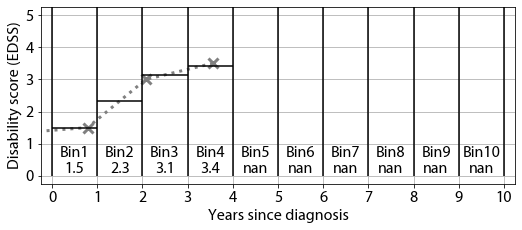

In [4]:
from code_utils import get_time_series

# Get data
ipatient = 116
t_visits, y_visits = get_time_series(edss, biom.ID[ipatient])
y_targets = y.loc[ipatient]

# Plot setup
plt.figure(figsize=(8.5, 3.25))
plt.xlim([-0.25, 10.25])
plt.ylim([-0.25, 5.25])
plt.xticks(range(11))
plt.yticks(range(6))
plt.grid()
plt.xlabel("Years since diagnosis")
plt.ylabel("Disability score (EDSS)")
# Plot measurements (true trajectory)
plt.plot(t_visits, y_visits, "x:", ms=10, mew=3, lw=3, c="gray")
# Plot binned means
plt.vlines(binedges, 0, 10, color="k")
for i in range(len(binedges)-1):
    meanval = y_targets[f"bin{i+1}"]
    plt.annotate(
        f"Bin{i+1}\n{meanval:.1f}",
        xy=((binedges[i+1]+binedges[i])/2, 0), xytext=(0, -0.5),
        textcoords="offset points", ha="center", va="bottom", fontsize=16
    )
    if not np.isnan(meanval):
        plt.hlines(meanval, binedges[i], binedges[i+1], "k", "solid", alpha=1.0)
plt.savefig("results/target_definition.png", dpi=300)
plt.show()

Then, the regressor chain of random forests is trained. This takes some time to train (10 minutes), so some functionality is provided to load the model if it exists (and otherwise, train it and save it). However, the trained model is not included with this code, as it would reveal too much about the underlying dataset.

In [5]:
from code_utils import CrossValidation, RegressorChain
from pct.forest.forest import RandomForest
import pickle

def fit_model():
    model = RegressorChain(RandomForest(
        min_instances=5, ftest=0.01, num_trees=50, random_state=42
    ))
    cv = CrossValidation(k=5, random_state=42)
    cv.fit(X, y, model)
    return cv

cv = saveload("results/model.pkl", fit_model)

"model.pkl" found, loading...


# 2. Compute permutation importances

First, we define some functionality to transform a prediction of the binned targets back to a prediction of the actual visits, and evaluate these predictions on MAE and Pearson correlation.

In [6]:
from code_utils import compute_MAE, compute_rho, pred_at_t

def score(y_pred_targets):
    """Scores a target prediction on the actual visits."""
    # Restrict to the window of the visits: at most 10 years after diagnosis
    i_visits = np.logical_and(0 <= edss.Years_Since_LP, edss.Years_Since_LP < 10)
    visits_time    = edss.Years_Since_LP[i_visits].values
    visits_pid     = edss.ID[i_visits].values

    y_true_visits  = edss.EDSS[i_visits]
    y_true_targets = y
    y_pred_targets = y_pred_targets.astype(float)
    y_pred_visits  = np.nan * np.zeros(len(y_true_visits))
    for i in range(len(y_true_visits)):
        i_patient = biom.index[biom.ID == visits_pid[i]]
        y_pred_visits[i] = pred_at_t(
            np.array(visits_time[i]), 
            binedges, 
            y_pred_targets.loc[i_patient].values.flatten(), 
            interp_kind="quadratic"
        )
    return np.array([
        compute_MAE(y_true_visits, y_pred_visits), # Mean Absolute Error
        compute_rho(y_true_visits, y_pred_visits)  # Pearson correlation
    ])

print(score(cv.y_pred.astype(float)))
print(score(cv.y_pred.astype(float)) == score(cv.predict_altered_dataset(X)))

[-1.12004025  0.72315856]


array([ True,  True])

Then, we compute the normal permutation feature importance scores. This also takes quite a while to train, so again we provide save/load functionality. This time, the scores are included in the repository, so you can also inspect them.

In [12]:
from tqdm import tqdm

n_repeats = 10
X_shuffled = X.copy()

# Permutation feature importance -- takes about 23 minutes
def compute_perm_imp():
    base_score = score(cv.predict_altered_dataset(X))
    perm_imp = dict()
    perm_imp["MAE"] = pd.DataFrame(index=range(n_repeats), columns=X.columns)
    perm_imp["rho"] = pd.DataFrame(index=range(n_repeats), columns=X.columns)
    for j in tqdm(X.columns):
        for k in range(n_repeats):
            X_shuffled[j] = np.random.permutation(X_shuffled[j])
            y_pred_targets = cv.predict_altered_dataset(X_shuffled)
            perm_imp["MAE"].loc[k,j] = (base_score - score(y_pred_targets))[0]
            perm_imp["rho"].loc[k,j] = (base_score - score(y_pred_targets))[1]
            X_shuffled[j] = X[j]
    return perm_imp

perm_imp = saveload("results/perm_imp.pkl", compute_perm_imp)

"perm_imp.pkl" found, loading...


Now let's plot the results. This results in the figure that was included in the paper.

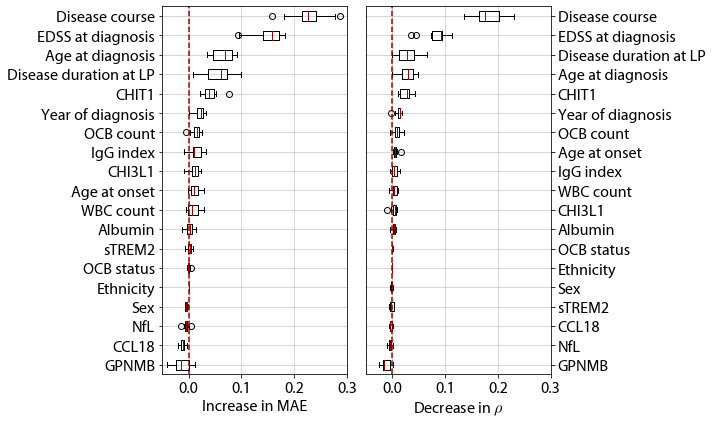

In [19]:
from code_utils import paper_varnames

fig, ax = plt.subplots(ncols=2, figsize=(10,6))
for i, metric in enumerate(["MAE","rho"]):
    avg = np.mean(perm_imp[metric], axis=0)
    isort = np.argsort(avg,axis=0)
    to_plot = perm_imp[metric].iloc[:,isort]
    labels  = pd.DataFrame(to_plot.columns).replace(paper_varnames).values.flatten()
    ax[i].boxplot(to_plot, vert=False, labels=labels, medianprops=dict(color="#A30000"))
    # ax[i].plot(drop_imp[isort,i], range(1,len(X.columns)+1), "kx")
    ax[i].set_xlabel(["Increase in MAE",r"Decrease in $\rho$"][i])
    ax[i].axvline(x=0, color="#A30000", linestyle="--")
    ax[i].grid(lw=0.5)
    ax[i].set_xticks([0, 0.1, 0.2, 0.3]) 
    ax[i].set_xlim([-0.05, 0.3])
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig("results/perm_imp.png", dpi=300)
plt.show()

# 3. Compute interaction importances

In this cell, we compute permutation importance scores for when any tuple of biomarkers, any triplet of biomarkers, any quadruplet of biomarkers and any quintuplet of biomarkers is shuffled. These scores are then normalized properly: by dividing both by the number of biomarkers that were shuffled (distribute score amongst variables) as well as by the number of committees that any of the biomarkers would be in (for example, every variable appears in 15 triplets).

In [20]:
from code_utils import biomarkernames
from itertools import combinations
from math import comb

n_repeats = 10
X_shuffled = X.copy()

def compute_klets_perm():
    # Timing info: shuffling...
    # ... 1 feature  took  9:03
    # ... 2 features took 20:40
    # ... 3 features took 24:37
    # ... 4 features took 18:55
    # ... 5 features took 10:25
    base_score = score(cv.predict_altered_dataset(X))
    perm_imp_mae = dict()
    perm_imp_rho = dict()
    for n_to_shuffle in range(1, len(biomarkernames)):
        to_shuffle = list(combinations(biomarkernames, n_to_shuffle))
        perm_imp_mae[n_to_shuffle] = pd.DataFrame(0.0, index=range(n_repeats), columns=biomarkernames)
        perm_imp_rho[n_to_shuffle] = pd.DataFrame(0.0, index=range(n_repeats), columns=biomarkernames)
        normalization = n_to_shuffle * comb(len(biomarkernames) - 1, n_to_shuffle - 1)
        for subset in tqdm(to_shuffle):
            for k in range(n_repeats):
                # Shuffle the dataset
                for var in subset:
                    X_shuffled[var] = np.random.permutation(X_shuffled[var])
                # Compute the results
                shuffled_score = score(cv.predict_altered_dataset(X_shuffled))
                for var in subset:
                    perm_imp_mae[n_to_shuffle].loc[k,var] += (base_score - shuffled_score)[0] / normalization
                    perm_imp_rho[n_to_shuffle].loc[k,var] += (base_score - shuffled_score)[1] / normalization
                # Unshuffle the dataset
                for var in subset:
                    X_shuffled[var] = X[var]
    return perm_imp_mae, perm_imp_rho

(perm_imp_mae, perm_imp_rho) = saveload("results/klets_perm.pkl", compute_klets_perm)

"klets_perm.pkl" found, loading...


Again, we plot the results.

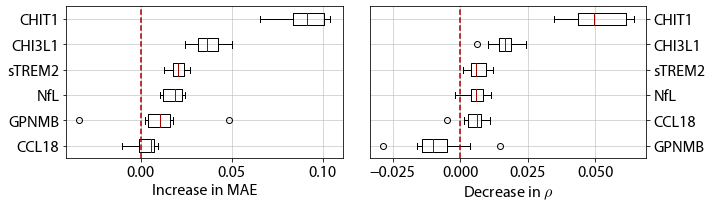

In [21]:
fig, ax = plt.subplots(figsize=(10, 3), ncols=2)

sum_perm_imp_mae = sum([perm_imp for perm_imp in perm_imp_mae.values()])
sum_perm_imp_rho = sum([perm_imp for perm_imp in perm_imp_rho.values()])

for j, perm_imp in enumerate([sum_perm_imp_mae, sum_perm_imp_rho]):
    isort = np.argsort(np.mean(perm_imp, axis=0), axis=0)
    labels = pd.Series(biomarkernames)[isort.values].replace(paper_varnames)
    ax[j].boxplot(perm_imp.iloc[:,isort], labels=labels, vert=False, medianprops=dict(color="#A30000"))
    ax[j].axvline(x=0, color="#A30000", linestyle="--")
    ax[j].grid(lw=0.5)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[0].set_xlabel("Increase in MAE")
ax[1].set_xlabel(r"Decrease in $\rho$")
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig("results/klets_perm.png", dpi=300)
plt.show()